# CQ Notebook

In [1]:
# General (scientific) computing
import os
import time
import glob
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib.patches import Ellipse
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# Astronomical computing
import fitsio
from astropy.visualization import simple_norm, AsinhStretch
#import astroalign as aa
import sep
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u

# Your Image Calibration and Photometry Code
from complete_process import average_bias, average_dark, average_flat, science_exposure
# Note that you do not need to have magnitude errors implemented. That is for lab 1.5! Returning 0 for all
# magnitude errors is fine for now.
from photometry import create_phot_cat, aper_flux

In [2]:
plt.rcParams["figure.figsize"] = (10,5)

## Calibrate Images

In [3]:
datadir = './data/'
outputdir = './output/'
caldir = datadir + 'Calibration/'
calibrateddatadir = datadir + 'Calibrated_Data/'

# These calibration files are for the first day of observing
early_biasfiles = glob.glob(caldir + 'Biases/2022_04_28/*.fit')
early_darkfiles = glob.glob(caldir + 'Darks/2022_04_06/*.fit')
early_Rflatfiles = glob.glob(caldir + 'Flats/2022_04_28/*R.fit')
early_Haflatfiles = glob.glob(caldir + 'Flats/2022_04_28/*Halpha.fit')

# These calibration files are for the first day of observing
late_biasfiles = glob.glob(caldir + 'Biases/2022_05_11/*.fit')
late_darkfiles = glob.glob(caldir + 'Darks/2022_05_11/*.fit')
late_Rflatfiles = glob.glob(caldir + 'Flats/2022_05_10/*R.fit')
late_Haflatfiles = glob.glob(caldir + 'Flats/2022_05_10/*Halpha.fit')

# Data files
early_CQ_Ha_files = sorted(glob.glob(datadir + 'CQ_M94/*04_*Ha*.fit'))
early_CQ_R_files = sorted(glob.glob(datadir + 'CQ_M94/*04_*R*.fit'))
late_CQ_Ha_files = sorted(glob.glob(datadir + 'CQ_M94/*5_*Ha*.fit'))
late_CQ_R_files = sorted(glob.glob(datadir + 'CQ_M94/*5_*R*.fit'))
#OS_Ha_files = glob.glob(datadir + 'M94/*Ha*.fit')
#OS_R_files = glob.glob(datadir + 'M94/*R*.fit')

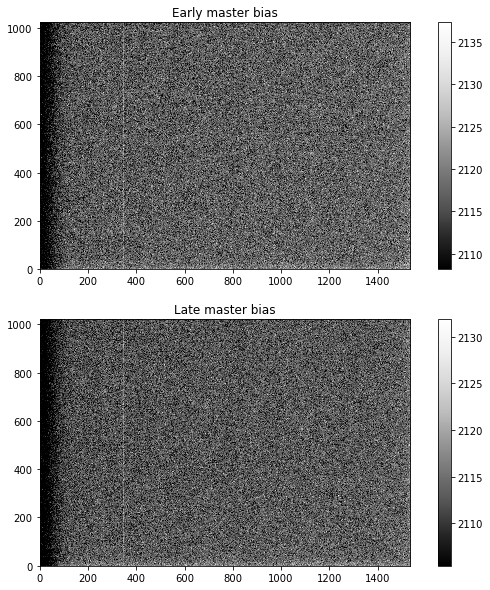

In [4]:
early_masterbias = average_bias(early_biasfiles)
late_masterbias = average_bias(late_biasfiles)
fig, axs = plt.subplots(2, figsize=(10,10))
im1 = axs[0].imshow(early_masterbias,vmin=np.median(early_masterbias)-2*np.std(early_masterbias),vmax=np.median(early_masterbias)+5*np.std(early_masterbias))
im2 = axs[1].imshow(late_masterbias,vmin=np.median(late_masterbias)-2*np.std(late_masterbias),vmax=np.median(late_masterbias)+5*np.std(late_masterbias))
axs[0].set_title("Early master bias")
axs[1].set_title("Late master bias")
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])
plt.show()

In [5]:
np.std(early_masterbias)

4.156994709424197

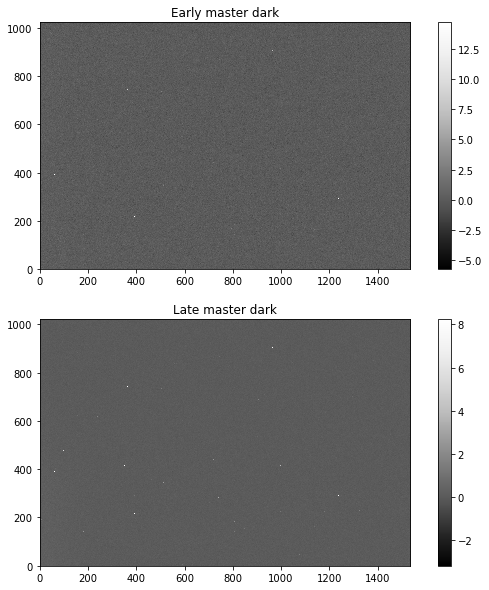

In [6]:
early_masterdark = average_dark(early_darkfiles, early_masterbias)
late_masterdark = average_dark(late_darkfiles, late_masterbias)
fig, axs = plt.subplots(2, figsize=(10,10))
im1 = axs[0].imshow(early_masterdark,vmin=np.median(early_masterdark)-2*np.std(early_masterdark),vmax=np.median(early_masterdark)+5*np.std(early_masterdark))
im2 = axs[1].imshow(late_masterdark,vmin=np.median(late_masterdark)-2*np.std(late_masterdark),vmax=np.median(late_masterdark)+5*np.std(late_masterdark))
axs[0].set_title("Early master dark")
axs[1].set_title("Late master dark")
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])
plt.show()

In [7]:
np.mean(early_masterdark)

0.07901512781778969

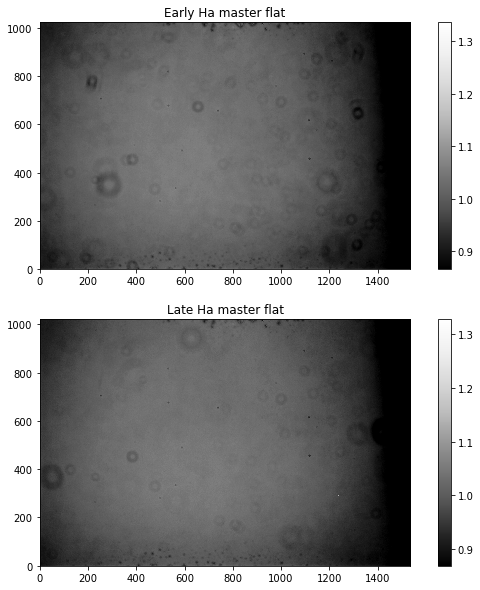

In [8]:
early_masterHaflat = average_flat(early_Haflatfiles, early_masterbias, early_masterdark)
late_masterHaflat = average_flat(late_Haflatfiles, late_masterbias, late_masterdark)
fig, axs = plt.subplots(2, figsize=(10,10))
im1 = axs[0].imshow(early_masterHaflat,vmin=np.median(early_masterHaflat)-2*np.std(early_masterHaflat),vmax=np.median(early_masterHaflat)+5*np.std(early_masterHaflat))
im2 = axs[1].imshow(late_masterHaflat,vmin=np.median(late_masterHaflat)-2*np.std(late_masterHaflat),vmax=np.median(late_masterHaflat)+5*np.std(late_masterHaflat))
axs[0].set_title("Early Ha master flat")
axs[1].set_title("Late Ha master flat")
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])
plt.show()

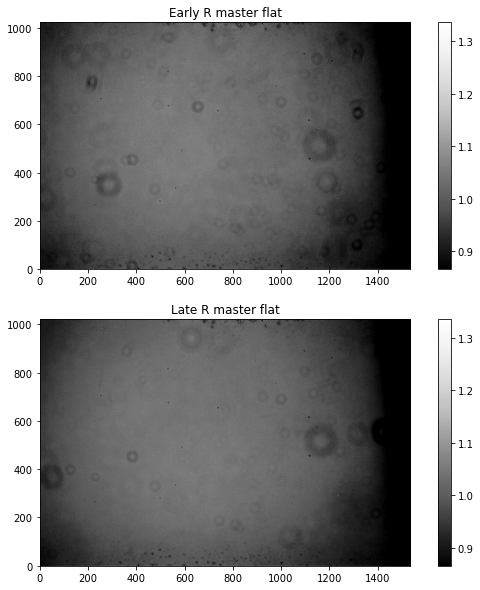

In [9]:
early_masterRflat = average_flat(early_Rflatfiles, early_masterbias, early_masterdark)
late_masterRflat = average_flat(late_Rflatfiles, late_masterbias, late_masterdark)
fig, axs = plt.subplots(2, figsize=(10,10))
im1 = axs[0].imshow(early_masterRflat,vmin=np.median(early_masterRflat)-2*np.std(early_masterRflat),vmax=np.median(early_masterRflat)+5*np.std(early_masterRflat))
im2 = axs[1].imshow(late_masterRflat,vmin=np.median(late_masterRflat)-2*np.std(late_masterRflat),vmax=np.median(late_masterRflat)+5*np.std(late_masterRflat))
axs[0].set_title("Early R master flat")
axs[1].set_title("Late R master flat")
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])
plt.show()

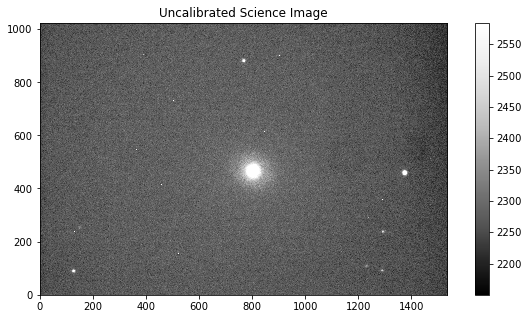

In [10]:
uncalsciim = fitsio.read(late_CQ_R_files[0])
plt.imshow(uncalsciim,vmin=np.median(uncalsciim)-2*np.std(uncalsciim),vmax=np.median(uncalsciim)+5*np.std(uncalsciim))
plt.colorbar()
plt.title("Uncalibrated Science Image")
plt.show()

In [11]:
# WRITE CALIBRATED FILES
print("Calibrating early Ha files")
for f in early_CQ_Ha_files:
    name = f[f.rfind('/') +1:]
    im = fitsio.read(f)
    header = fitsio.read_header(f)
    header["BZERO"] = 0
    calim = science_exposure(im, header, early_masterbias, early_masterdark, early_masterHaflat)
    fitsio.write(calibrateddatadir + 'Ha/cal_' + name, calim, clobber=True, header=header)
    
print("Calibrating late Ha files")
for f in late_CQ_Ha_files:
    name = f[f.rfind('/') +1:]
    im = fitsio.read(f)
    header = fitsio.read_header(f)
    header["BZERO"] = 0
    calim = science_exposure(im, header, late_masterbias, late_masterdark, late_masterHaflat)
    fitsio.write(calibrateddatadir + 'Ha/cal_' + name, calim, clobber=True, header=header)
    
print("Calibrating early R files")
for f in early_CQ_R_files:
    name = f[f.rfind('/') +1:]
    im = fitsio.read(f)
    header = fitsio.read_header(f)
    header["BZERO"] = 0
    calim = science_exposure(im, header, early_masterbias, early_masterdark, early_masterHaflat)
    fitsio.write(calibrateddatadir + 'R/cal_' + name, calim, clobber=True, header=header)
    
print("Calibrating late R files")
for f in late_CQ_R_files:
    name = f[f.rfind('/') +1:]
    im = fitsio.read(f)
    header = fitsio.read_header(f)
    header["BZERO"] = 0
    calim = science_exposure(im, header, late_masterbias, late_masterdark, late_masterHaflat)
    fitsio.write(calibrateddatadir + 'R/cal_' + name, calim, clobber=True, header=header)

Calibrating early Ha files
Calibrating late Ha files
Calibrating early R files
Calibrating late R files


In [12]:
# Calibrated CQ Ha files
CQ_Ha_cal_files = sorted(glob.glob(calibrateddatadir + "Ha/*.fit"))
CQ_R_cal_files = sorted(glob.glob(calibrateddatadir + "R/*.fit"))

In [13]:
CQ_Ha_cal_files[0]

'./data/Calibrated_Data/Ha/cal_CQ_M94_2022_04_28-001Ha.fit'

In [14]:
im, header = fitsio.read(early_CQ_Ha_files[0], header=True)
header["BZERO"]

32768.0

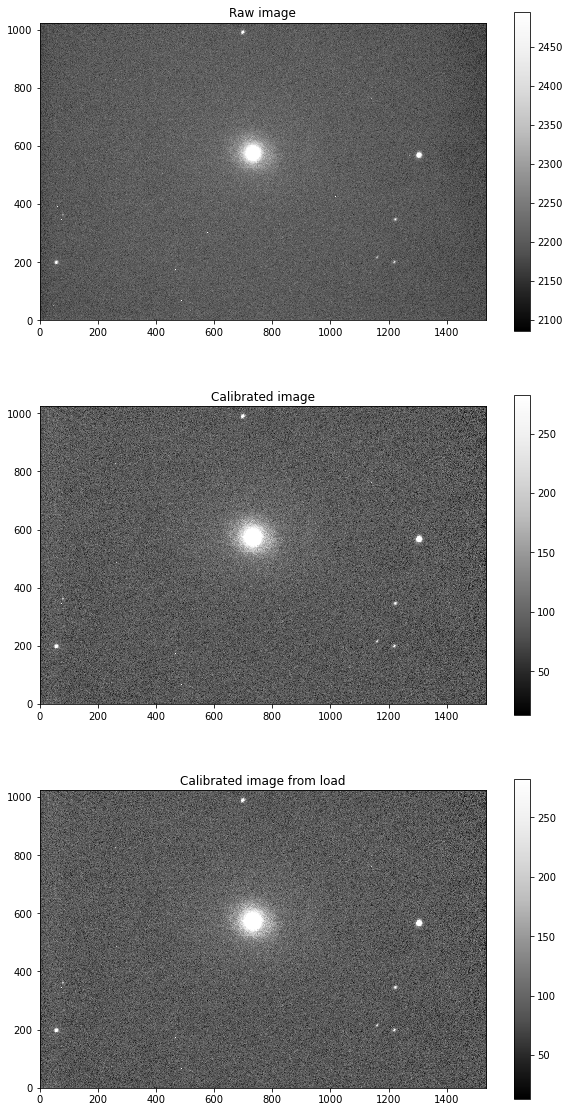

In [17]:
fig, axs = plt.subplots(3, figsize=(10,20))
im, header = fitsio.read(late_CQ_R_files[-1], header=True)
calim = science_exposure(im, header, late_masterbias, late_masterdark, late_masterHaflat)
calim2 = fitsio.read(CQ_R_cal_files[-1])
im1 = axs[0].imshow(im, vmin=np.median(im)-2*np.std(im), vmax=np.median(im)+5*np.std(im))
im2 = axs[1].imshow(calim, vmin=np.median(calim)-2*np.std(calim), vmax=np.median(calim)+5*np.std(calim))
im3 = axs[2].imshow(calim2, vmin=np.median(calim2)-2*np.std(calim2), vmax=np.median(calim2)+5*np.std(calim2))
axs[0].set_title("Raw image")
axs[1].set_title("Calibrated image")
axs[2].set_title("Calibrated image from load")
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])
fig.colorbar(im3,ax=axs[2])
plt.show()

## Image Stacking

In [21]:
aligned_R = sorted(glob.glob(datadir + 'Aligned_Data/R/*'))
aligned_Ha = sorted(glob.glob(datadir + 'Aligned_Data/Ha/*'))

In [24]:
xsz, ysz = fitsio.read(aligned_R[0]).shape
stack_R = np.zeros((len(aligned_R),xsz,ysz))
stack_Ha = np.zeros((len(aligned_Ha),xsz,ysz))

print("Stacking the R images")
tot_exptime_R = 0
for i, f in enumerate(aligned_R):
    exptime = fitsio.read_header(f)["EXPTIME"]
    tot_exptime_R += exptime
    stack_R[i] = fitsio.read(f) / exptime
header = fitsio.read_header(aligned_R[0])
final_R = np.median(stack_R, axis=0)
header['NCOMBINE'] = len(aligned_R)
header['EXPTIME'] = tot_exptime_R
header['EXPOSURE'] = tot_exptime_R
coadd_R_filename = datadir + 'Coadded_Data/coadded_R.fit'
fitsio.write(coadd_R_filename, final_R, header=header, clobber=True)

print("Stacking the Ha images")
tot_exptime_Ha = 0
for i, f in enumerate(aligned_Ha):
    exptime = fitsio.read_header(f)["EXPTIME"]
    tot_exptime_Ha += exptime
    stack_Ha[i] = fitsio.read(f) / exptime
header = fitsio.read_header(aligned_Ha[0])
final_Ha = np.median(stack_Ha, axis=0)
header['NCOMBINE'] = len(aligned_Ha)
header['EXPTIME'] = tot_exptime_Ha
header['EXPOSURE'] = tot_exptime_Ha
coadd_Ha_filename = datadir + 'Coadded_Data/coadded_Ha.fit'
fitsio.write(coadd_Ha_filename, final_Ha, header=header, clobber=True)

Stacking the R images
Stacking the Ha images


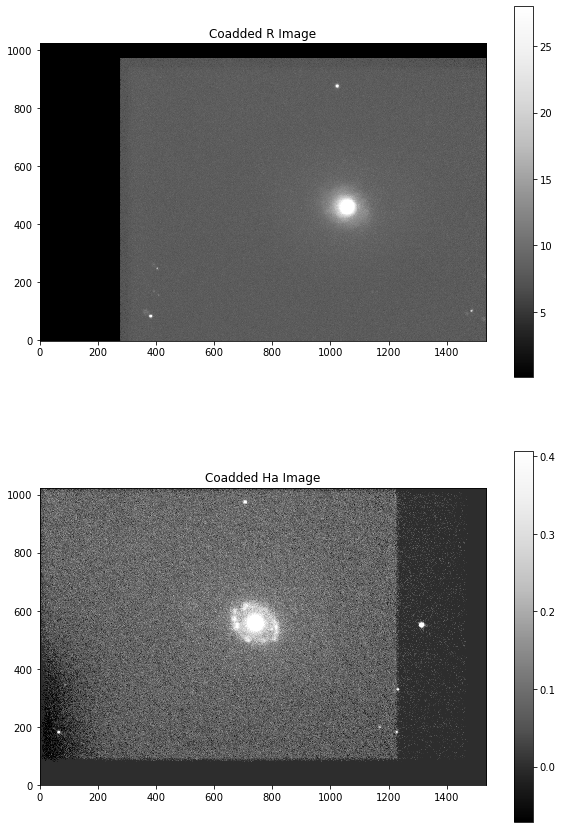

In [30]:
fig, axs = plt.subplots(2, figsize=(10,15))
imR, headerR = fitsio.read(coadd_R_filename, header=True)
imHa, headerHa = fitsio.read(coadd_Ha_filename, header=True)
im1 = axs[0].imshow(imR, vmin=np.median(imR)-2*np.std(imR), vmax=np.median(imR)+5*np.std(imR))
im2 = axs[1].imshow(imHa, vmin=np.median(imHa)-2*np.std(imHa), vmax=np.median(imHa)+5*np.std(imHa))
axs[0].set_title("Coadded R Image")
axs[1].set_title("Coadded Ha Image")
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])
plt.show()

## SNR (This is broken)

In [16]:
uncalsciim, header = fitsio.read(CQ_Ha_files[0], header=True)
calim = science_exposure(uncalsciim, header, masterbias, masterdark, masterHaflat)

fluxHa, _, _ = aper_flux(calim, 1045, 461, source_radius=200, background_width=200, gain=1.2706268068331685, exptime=60)
fluxHa

NameError: name 'CQ_Ha_files' is not defined

In [ ]:
uncalsciim, header = fitsio.read(CQ_R_files[0], header=True)
calim = science_exposure(uncalsciim, header, masterbias, masterdark, masterRflat)

fluxR, _, _ = aper_flux(calim, 1045, 461, source_radius=200, background_width=200, gain=1.2706268068331685, exptime=60)
fluxR

In [ ]:
DW = 13462.1 / 306.75
DW

In [ ]:
fluxR

In [ ]:
RN = np.std(masterbias)
D = np.mean(masterdark)
n = 125629
#DW = 106.56 / 3
gain = 1.27
sky_Ha = 26838.41
sky_R = 5160525.85
t_Ha = np.linspace(0.0001, 4 * 3600, 1000)
t_R = t_Ha / (DW)
i_Ha = t_Ha / 60
i_R = t_R / 60

'''t_Ha = 3*3600
t_R = t_Ha / DW
i_Ha = t_Ha / 60
i_R = t_R / 15'''

S = (fluxHa * t_Ha) - (fluxR * t_R)
N2 = (fluxHa * t_Ha) + (sky_Ha * t_Ha) + (D * t_Ha * n * gain) + ((RN ** 2) * n * i_Ha * gain) + (sky_R*t_R) + (fluxR * t_R) + (D * t_R * n * gain) + ((RN ** 2) * n * i_R * gain)
N = np.sqrt(N2)

#S = (fluxHa * t_Ha) - (fluxR * t_R / DW)
#N = np.sqrt((fluxHa * t_Ha) + (D * t_Ha * n * i_Ha * gain) + ((RN ** 2) * n * i_Ha * gain) + ((fluxR * t_R + (D * t_R * n * i_R * gain) + ((RN ** 2) * n * i_R * gain)) / (DW ** 2)))


S_Ha = (fluxHa * t_Ha)
S_R = (fluxR * t_R)
N_Ha = np.sqrt((fluxHa * t_Ha) + sky_Ha  * t_Ha + (D * t_Ha * n * gain) + ((RN ** 2) * n * i_Ha * gain))
N_R = np.sqrt((sky_R*t_R + fluxR * t_R + (D * t_R * n * gain) + ((RN ** 2) * n * i_R * gain)))
print(N_Ha[-1]/N_R[-1])

'''print(fluxHa * t_Ha)
print(sky_Ha  * t_Ha)
print((D * t_Ha * n * i_Ha * gain))
print(((RN ** 2) * n * i_Ha * gain))
print(sky_R*t_R)
print(fluxR * t_R)
print((D * t_R * n * i_R * gain))
print((((RN ** 2) * n * i_R * gain)) / (DW ** 2))'''

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot((t_Ha + t_R) / 60, S/N)
#plt.plot((t_Ha) / 60, S_Ha/N_Ha)
#plt.plot((t_R) / 60, S_R/N_R)
plt.title('Signal-to-Noise Ratio vs. Total Exposure Time', size=20)
plt.xlabel('Total Exposure Time (min)', size=15)
plt.ylabel('SNR', size=15)
plt.axvline(60, linestyle='--', color='gray')
plt.axvline(2*60, linestyle='--', color='gray')
plt.axvline(3*60, linestyle='--', color='gray')
plt.axvline(4*60, linestyle='--', color='gray')

plt.grid()
plt.show()